In [1]:
"""
Author: ***
Code to produce the results obtained in VIGN: Variational Integrator Graph Networks

"""

from data_builder import *
from utils import *
import torch
import numpy as np
import matplotlib.pyplot as plt

# %%

num_trajectories = 20
n_test_traj = 2
num_nodes = 2
T_max = 10.01
T_max_t = 10.01
dt = 0.01
srate = 0.01
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

train_data = pend_chaos(num_trajectories, T_max, dt, srate, 0)#pendulum(num_trajectories, T_max, dt, srate, noise_std=0, seed=3)
valid_data = pend_chaos(n_test_traj, T_max_t, dt, srate, 0)#pendulum(n_test_traj, T_max_t, dt, srate, noise_std=0, seed=5)
print(train_data['x'].shape)
tnow, tnext, tenergy, tdx,tevals = nownext(train_data, num_trajectories, T_max, dt, srate)
vnow, vnext, venergy, vdx,vevals = nownext(valid_data, n_test_traj, T_max_t, dt, srate)
print(tnow.shape)

traindat = pendpixdata(tnow, tnext, tenergy, tdx,tevals)
train_dataloader = DataLoader(traindat, batch_size=1500, num_workers=2, shuffle=True)
valdat = pendpixdata(vnow, vnext, venergy, vdx,vevals)
val_dataloader = DataLoader(valdat, batch_size=1500, num_workers=2, shuffle=False)

data_dict = {'train': train_dataloader, 'valid': val_dataloader}
running_losses = 0.
loss_collater = {'train': [], 'valid': []}

torch.pi = torch.tensor(np.pi)


def train_model(model, optimizer,lr_sched, num_epochs=1, energy_term=False, integrator_embedded=False, reg_grad=False):
    for epoch in range(num_epochs):
        print('epoch:{}'.format(epoch))

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                # scheduler.step()
                model.train()
            else:
                model.eval()
            lr_sched.step()
            running_loss = 0.0
            # Iterate over data.
            for batch_i, (q, q_next, energy_, qdx,tevals) in enumerate(data_dict[phase]):
                if phase == 'train':
                    optimizer.zero_grad()
                q, q_next, qdx = q.float(), q_next.float(), qdx.float()
                q.to(device)
                q_next.to(device)
                energy_.to(device)
                qdx.to(device)
                tevals = tevals.float()
                tevals.to(device)
                loss = 0
                q.requires_grad = True
                tevals.requires_grad = True

                if integrator_embedded:
                    next_step_pred = model.next_step(q,tevals)
                    state_loss = torch.mean((next_step_pred - q_next) ** 2)
                else:
                    next_step_pred = model.time_deriv(q,tevals)
                    state_loss = torch.mean((next_step_pred - qdx) ** 2)

                loss = state_loss
                print(f'{phase} state loss {state_loss}')

                beta = 1e-5

                if energy_term:
                    f1 = model.get_H(torch.cat([q,tevals.reshape(-1,1)],1))
                    energy_loss = ((f1 - energy_) ** 2).mean()
                    print(f'{phase} energy loss {energy_loss}')
                    loss += beta*energy_loss

                lambda_ = 1

                if reg_grad:
                    dhdt,dfdq,dfdp = model.time_deriv2(q, tevals)
                    c1 = torch.mean(torch.square(dhdt))
                    c2 = torch.mean(torch.square(dfdq))
                    c3 = torch.mean(torch.square(dfdp))
                    loss += c1 + c2 + c3

                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                running_loss += state_loss

            loss_collater[phase].append(running_loss)
            epoch_loss = running_loss
            print('{} Loss: {:.10f}'.format(phase, epoch_loss))

    plt.figure()
    plt.plot(loss_collater['train'], label='train')
    plt.plot(loss_collater['valid'], label='valid')
    plt.yscale('log')
    plt.title(f'simple pendulum: ntrain_inits:{num_trajectories},ntest_inits:{n_test_traj},tmax:{T_max},dt:{dt}')
    plt.legend()
    plt.show()
    #
    #
    #
    # preds = []
    # pred_ham = []
    # qinit = q[0].reshape(1, -1)
    # for i in range(len(q_next)):
    #     next_step_pred = model.next_step(qinit,tevals[i])
    #     pred_ham.append(model.get_H(torch.cat([qinit,tevals[i].reshape(-1,1)],1)))
    #     preds.append(next_step_pred)
    #     qinit = next_step_pred
    #
    # # pred_ham = torch.cat(pred_ham)
    #
    # # plt.figure()
    # # plt.scatter(range(len(q_next)),pred_ham.detach().numpy())
    # # plt.show()
    #
    # preds = torch.cat(preds)
    # preds = preds.detach().numpy()
    # q_next = q_next.detach().numpy()
    #
    # plt.figure()
    # plt.scatter(range(len(preds)),np.mean(np.abs(preds-q_next),1))
    # plt.show()
    #
    #
    # print(np.mean((preds-q_next)**2))
    # plt.figure()
    # plt.plot(preds[:, 0], preds[:, 1], label='predicted')
    # plt.plot(q_next[:, 0], q_next[:, 1], label='true')
    # plt.scatter(preds[:, 0], preds[:, 1], label='predicted', s=3)
    # plt.scatter(q_next[:, 0], q_next[:, 1], label='true', s=3)
    # plt.legend()
    # plt.show()
    return model
# model_ft = HNN(2, 200, 1, 0.01)


cpu
(20020, 2)
(20000, 2)


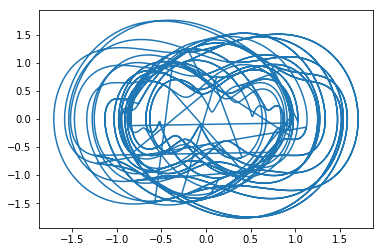

In [10]:
plt.plot(train_data['x'][:,0],train_data['x'][:,1])


In [5]:
from model import HNN as HNN1
model_ft = HNN1(3, 200, 1, srate)
params = list(model_ft.parameters())
optimizer_ft = torch.optim.Adam(params, 1e-3)
lr_sched = torch.optim.lr_scheduler.StepLR(optimizer_ft,250,gamma=0.1)
trained_model1 = train_model(model_ft, optimizer_ft,lr_sched, num_epochs=200, energy_term=False,integrator_embedded=False, reg_grad=False)


epoch:0
train state loss 6.936915451660752e-05
train state loss 6.558315362781286e-05
train state loss 6.408696935977787e-05
train state loss 6.189735722728074e-05
train state loss 6.344939902191982e-05
train state loss 5.8633821026887745e-05
train state loss 5.83837681915611e-05
train state loss 5.470540054375306e-05
train state loss 5.242097904556431e-05
train state loss 4.842847920372151e-05
train state loss 4.302203524275683e-05
train state loss 3.939024463761598e-05
train state loss 3.1862240575719625e-05
train state loss 2.3654738470213488e-05
train Loss: 0.0007348877
valid state loss 2.1185747755225748e-05
valid state loss 2.3606315153301693e-05
valid Loss: 0.0000447921
epoch:1
train state loss 2.2664549760520458e-05
train state loss 1.912708285090048e-05
train state loss 1.978735235752538e-05
train state loss 1.753738433762919e-05
train state loss 1.8009352061199024e-05
train state loss 1.6884943761397153e-05
train state loss 1.7718835806590505e-05
train state loss 1.5100627024

valid state loss 1.1506460396049079e-05
valid state loss 1.1865623491758015e-05
valid Loss: 0.0000233721
epoch:12
train state loss 1.1775109669542871e-05
train state loss 1.2718865946226288e-05
train state loss 1.2435165444912855e-05
train state loss 1.2726807653962169e-05
train state loss 1.2527326362032909e-05
train state loss 1.2358354979369324e-05
train state loss 1.1729851394193247e-05
train state loss 1.3115686670062132e-05
train state loss 1.2355538274277933e-05
train state loss 1.2774288734362926e-05
train state loss 1.2815106856578495e-05
train state loss 1.1785711649281438e-05
train state loss 1.2672931006818544e-05
train state loss 1.2557995432871394e-05
train Loss: 0.0001743487
valid state loss 1.15300172183197e-05
valid state loss 1.237843116541626e-05
valid Loss: 0.0000239084
epoch:13
train state loss 1.2025696378259454e-05
train state loss 1.1495066246425267e-05
train state loss 1.2740614693029784e-05
train state loss 1.2312700164329726e-05
train state loss 1.29244217532

KeyboardInterrupt: 

epoch:0
train state loss 9.416220564162359e-05
train state loss 0.002817867323756218
train state loss 0.000619663274846971
train state loss 0.0001496143377153203
train state loss 0.00017855527403298765
train state loss 0.00025643431581556797
train state loss 0.0001664419105509296
train state loss 8.5796884377487e-05
train state loss 9.39939491217956e-05
train state loss 0.00012419930135365576
train state loss 0.00012145432992838323
train state loss 9.4011498731561e-05
train state loss 8.028861338971183e-05
train state loss 8.544031879864633e-05
train Loss: 0.0049679228
valid state loss 9.700439113657922e-05
valid state loss 0.0001226474269060418
valid Loss: 0.0002196518
epoch:1
train state loss 0.00010040584311354905
train state loss 0.000101248559076339
train state loss 9.420706919627264e-05
train state loss 8.056557271629572e-05
train state loss 7.118412759155035e-05
train state loss 7.541417289758101e-05
train state loss 8.121822611428797e-05
train state loss 7.629468746017665e-05
t

train state loss 1.950257683347445e-05
train state loss 2.0429162759683095e-05
train state loss 1.9236375010223128e-05
train state loss 1.886883364932146e-05
train state loss 1.9259068722021766e-05
train state loss 1.8233184164273553e-05
train state loss 1.9218976376578212e-05
train state loss 1.933712701429613e-05
train state loss 1.967753814824391e-05
train state loss 1.8492795788915828e-05
train state loss 1.891930696729105e-05
train state loss 1.9309325580252334e-05
train state loss 1.8188267858931795e-05
train state loss 1.8940880181617104e-05
train Loss: 0.0002676134
valid state loss 1.1753531907743309e-05
valid state loss 1.0919656233454589e-05
valid Loss: 0.0000226732
epoch:13
train state loss 2.05328924494097e-05
train state loss 1.918946873047389e-05
train state loss 1.8374965293332934e-05
train state loss 1.879350202216301e-05
train state loss 1.87692312465515e-05
train state loss 1.835729563026689e-05
train state loss 1.9823317416012287e-05
train state loss 1.92352672456763

valid state loss 8.225974852393847e-06
valid state loss 1.0647091585269663e-05
valid Loss: 0.0000188731
epoch:24
train state loss 1.0688030670280568e-05
train state loss 1.1534511941135861e-05
train state loss 1.0377326361776795e-05
train state loss 1.154828532889951e-05
train state loss 1.0848081728909165e-05
train state loss 1.0042061148851644e-05
train state loss 9.620717719371896e-06
train state loss 1.0127828318218235e-05
train state loss 1.0291877515555825e-05
train state loss 9.946638783731032e-06
train state loss 1.0343422218284104e-05
train state loss 9.736227184475865e-06
train state loss 1.0260275303153321e-05
train state loss 1.0829815437318757e-05
train Loss: 0.0001461951
valid state loss 6.826356184319593e-06
valid state loss 8.128498848236632e-06
valid Loss: 0.0000149549
epoch:25
train state loss 1.0309939170838334e-05
train state loss 1.2212953151902184e-05
train state loss 1.1497696505102795e-05
train state loss 9.43940358411055e-06
train state loss 1.0940748325083405e

valid state loss 4.878476829617284e-06
valid state loss 5.905622401769506e-06
valid Loss: 0.0000107841
epoch:36
train state loss 5.664408945449395e-06
train state loss 6.650899649685016e-06
train state loss 4.733045898319688e-06
train state loss 6.159701570140896e-06
train state loss 6.746393864887068e-06
train state loss 4.210035513096955e-06
train state loss 5.702529506379506e-06
train state loss 5.3349340305430815e-06
train state loss 3.858308446069714e-06
train state loss 7.258766800077865e-06
train state loss 5.684764346369775e-06
train state loss 4.339598035585368e-06
train state loss 6.7774212766380515e-06
train state loss 4.9490854507894255e-06
train Loss: 0.0000780699
valid state loss 4.966160759067861e-06
valid state loss 2.6572854494588682e-06
valid Loss: 0.0000076234
epoch:37
train state loss 4.5784731810272206e-06
train state loss 6.235862656467361e-06
train state loss 4.0580466702522244e-06
train state loss 5.128484190208837e-06
train state loss 5.170326858205954e-06
trai

valid state loss 3.7248066746542463e-06
valid state loss 5.564247203437844e-06
valid Loss: 0.0000092891
epoch:48
train state loss 3.608038241509348e-06
train state loss 2.563790758358664e-06
train state loss 2.0688919448730303e-06
train state loss 2.1643068066623528e-06
train state loss 3.509645694066421e-06
train state loss 3.1977258458937285e-06
train state loss 2.522718205000274e-06
train state loss 1.8839486983779352e-06
train state loss 2.7854414383909898e-06
train state loss 3.698803993756883e-06
train state loss 2.9584334697574377e-06
train state loss 2.0538609533105046e-06
train state loss 2.397196340098162e-06
train state loss 2.4800037863315083e-06
train Loss: 0.0000378928
valid state loss 2.5398837806278607e-06
valid state loss 1.5835380509088282e-06
valid Loss: 0.0000041234
epoch:49
train state loss 2.335868884983938e-06
train state loss 2.3468835479434347e-06
train state loss 2.3826521555747604e-06
train state loss 2.8882961942144902e-06
train state loss 3.0281544241006486

train Loss: 0.0000159934
valid state loss 1.0033450053015258e-06
valid state loss 1.2320722362346714e-06
valid Loss: 0.0000022354
epoch:60
train state loss 9.836738854573923e-07
train state loss 1.1941838238271885e-06
train state loss 1.3988575346957077e-06
train state loss 1.3827378779751598e-06
train state loss 9.445339514968509e-07
train state loss 1.1321126294205897e-06
train state loss 1.0767962521640584e-06
train state loss 1.3100964224577183e-06
train state loss 9.274417038795946e-07
train state loss 9.162146739072341e-07
train state loss 1.0518389217395452e-06
train state loss 1.0315878853361937e-06
train state loss 1.0630067208694527e-06
train state loss 1.0507967544981511e-06
train Loss: 0.0000154639
valid state loss 9.019183266900654e-07
valid state loss 1.230351927006268e-06
valid Loss: 0.0000021323
epoch:61
train state loss 1.0081312211696059e-06
train state loss 1.1091290161857614e-06
train state loss 1.3180635960452491e-06
train state loss 1.0388439477537759e-06
train st

train state loss 9.701816452434286e-07
train Loss: 0.0000135514
valid state loss 1.223215008394618e-06
valid state loss 2.721832743191044e-06
valid Loss: 0.0000039450
epoch:72
train state loss 1.6680143062330899e-06
train state loss 1.8398369547867333e-06
train state loss 1.0679950719350018e-06
train state loss 7.636224381712964e-07
train state loss 1.0443287692396552e-06
train state loss 1.1178692602697993e-06
train state loss 8.933469075600442e-07
train state loss 7.71927432197117e-07
train state loss 7.136084718695201e-07
train state loss 9.804342653296771e-07
train state loss 1.002082171908114e-06
train state loss 8.481841291541059e-07
train state loss 6.373417704708118e-07
train state loss 8.913265787668934e-07
train Loss: 0.0000142399
valid state loss 1.2955448482898646e-06
valid state loss 8.582945270063647e-07
valid Loss: 0.0000021538
epoch:73
train state loss 9.998107088904362e-07
train state loss 8.839663223625394e-07
train state loss 6.784605943721544e-07
train state loss 7.

train state loss 6.712868412250828e-07
train Loss: 0.0000135848
valid state loss 5.561511216001236e-07
valid state loss 8.089294283308845e-07
valid Loss: 0.0000013651
epoch:84
train state loss 6.568437811438343e-07
train state loss 6.633192697336199e-07
train state loss 6.3503756564387e-07
train state loss 6.42999395950028e-07
train state loss 6.528063067889889e-07
train state loss 7.042720540084701e-07
train state loss 6.559928920069069e-07
train state loss 4.7523494117740483e-07
train state loss 7.685491709708003e-07
train state loss 1.0194777360084117e-06
train state loss 1.5880007140367525e-06
train state loss 2.7440567009762162e-06
train state loss 2.7510900508787017e-06
train state loss 2.0832794689340517e-06
train Loss: 0.0000160410
valid state loss 1.1364392094037612e-06
valid state loss 1.3083347312203841e-06
valid Loss: 0.0000024448
epoch:85
train state loss 1.36808830575319e-06
train state loss 1.1018687473551836e-06
train state loss 1.8083285340253497e-06
train state loss 1

train state loss 2.255015942864702e-07
train Loss: 0.0000045616
valid state loss 2.2376197250650876e-07
valid state loss 3.5774161233348423e-07
valid Loss: 0.0000005815
epoch:96
train state loss 2.7552530923458107e-07
train state loss 3.457611796875426e-07
train state loss 4.6883707227607374e-07
train state loss 6.07375454819703e-07
train state loss 7.050540489217383e-07
train state loss 7.437413387378911e-07
train state loss 5.118229751133185e-07
train state loss 3.7534431385211064e-07
train state loss 2.398102196821128e-07
train state loss 4.891977596344077e-07
train state loss 6.051721470612392e-07
train state loss 7.839080922167341e-07
train state loss 5.526612198991643e-07
train state loss 4.773727937390504e-07
train Loss: 0.0000071816
valid state loss 5.730646535084816e-07
valid state loss 3.503871255361446e-07
valid Loss: 0.0000009235
epoch:97
train state loss 4.780189897246601e-07
train state loss 4.4719567426909634e-07
train state loss 3.05521353993754e-07
train state loss 2.5

train state loss 5.145305976839154e-07
train state loss 3.7017554177509737e-07
train Loss: 0.0000101930
valid state loss 3.06241531689011e-07
valid state loss 4.176658023880009e-07
valid Loss: 0.0000007239
epoch:108
train state loss 3.629432114848896e-07
train state loss 2.898683817420533e-07
train state loss 4.5683228222515027e-07
train state loss 4.315394619425206e-07
train state loss 4.472522618925723e-07
train state loss 3.171797970935586e-07
train state loss 3.117294511412183e-07
train state loss 3.037568774288957e-07
train state loss 2.701852110931213e-07
train state loss 3.534696304541285e-07
train state loss 3.4435350926287356e-07
train state loss 3.1627973839931656e-07
train state loss 3.445096581344842e-07
train state loss 2.399627589966258e-07
train Loss: 0.0000047899
valid state loss 1.9818067187316046e-07
valid state loss 1.5535815123257635e-07
valid Loss: 0.0000003535
epoch:109
train state loss 1.9968285869254032e-07
train state loss 3.34024349513129e-07
train state loss 

train state loss 1.3614182137189346e-07
train state loss 1.5023974242467375e-07
train Loss: 0.0000021542
valid state loss 1.4575276452433172e-07
valid state loss 1.388801820212393e-07
valid Loss: 0.0000002846
epoch:120
train state loss 1.4099593670380273e-07
train state loss 1.7131559104655025e-07
train state loss 2.3269410576176597e-07
train state loss 2.48533979174681e-07
train state loss 2.065712152443666e-07
train state loss 1.6253058277015953e-07
train state loss 1.6089852294953744e-07
train state loss 1.5586830670599738e-07
train state loss 1.3911821383771894e-07
train state loss 1.2595039322604862e-07
train state loss 1.1140593869640725e-07
train state loss 9.38337265665723e-08
train state loss 1.1468811322856709e-07
train state loss 1.2966403062364407e-07
train Loss: 0.0000021941
valid state loss 1.4050120000774768e-07
valid state loss 1.070956159310299e-07
valid Loss: 0.0000002476
epoch:121
train state loss 1.3353371741686715e-07
train state loss 1.0676533435116653e-07
train s

train state loss 6.635493576823137e-08
train state loss 6.679559305666771e-08
train Loss: 0.0000009375
valid state loss 5.5480413152508845e-08
valid state loss 8.259408446065208e-08
valid Loss: 0.0000001381
epoch:132
train state loss 6.904325289269764e-08
train state loss 6.418320452894477e-08
train state loss 7.457348516481943e-08
train state loss 6.767482574332462e-08
train state loss 7.026926596154226e-08
train state loss 6.052421497315663e-08
train state loss 6.109760164463296e-08
train state loss 6.790664031086635e-08
train state loss 6.708988564696483e-08
train state loss 6.881551684045917e-08
train state loss 6.031778099213625e-08
train state loss 6.268174246315539e-08
train state loss 5.937906166764151e-08
train state loss 5.607946462760083e-08
train Loss: 0.0000009096
valid state loss 5.420592685823067e-08
valid state loss 7.688977632369642e-08
valid Loss: 0.0000001311
epoch:133
train state loss 6.22195912569623e-08
train state loss 6.041806699386143e-08
train state loss 6.958

train Loss: 0.0000008069
valid state loss 4.701643874227557e-08
valid state loss 6.148301423536395e-08
valid Loss: 0.0000001085
epoch:144
train state loss 5.791666168875054e-08
train state loss 5.7525674890257505e-08
train state loss 6.184117040675119e-08
train state loss 5.2517542314944876e-08
train state loss 5.733329899726414e-08
train state loss 5.454146645433866e-08
train state loss 5.6906419132474184e-08
train state loss 6.005338093473256e-08
train state loss 5.850957762731923e-08
train state loss 5.744562514564677e-08
train state loss 5.7680139775584394e-08
train state loss 5.694493410146606e-08
train state loss 5.594202434622275e-08
train state loss 4.855117197166692e-08
train Loss: 0.0000007937
valid state loss 4.893782445947181e-08
valid state loss 6.431023535924396e-08
valid Loss: 0.0000001132
epoch:145
train state loss 5.668741209774453e-08
train state loss 6.032780675013782e-08
train state loss 5.783008560911185e-08
train state loss 5.7910327200261236e-08
train state loss 

valid state loss 4.4215862970986564e-08
valid state loss 6.472060221085485e-08
valid Loss: 0.0000001089
epoch:156
train state loss 5.290745619390691e-08
train state loss 5.6700809381027284e-08
train state loss 4.976530831868331e-08
train state loss 5.1628166630734995e-08
train state loss 4.9320689754495106e-08
train state loss 5.227564159326903e-08
train state loss 5.30194377290627e-08
train state loss 4.983014179060774e-08
train state loss 5.27664347771406e-08
train state loss 5.338565145507346e-08
train state loss 5.374669242996788e-08
train state loss 6.119638129575833e-08
train state loss 5.0371109949765014e-08
train state loss 4.7294946625697776e-08
train Loss: 0.0000007342
valid state loss 4.5324764386123206e-08
valid state loss 5.1442519577449275e-08
valid Loss: 0.0000000968
epoch:157
train state loss 5.560411153737732e-08
train state loss 4.875215253719034e-08
train state loss 4.961825794680408e-08
train state loss 5.5861747227936576e-08
train state loss 5.193869512254423e-08
t

train state loss 4.4345970451331596e-08
train Loss: 0.0000006748
valid state loss 4.0657486266582055e-08
valid state loss 5.113639645060175e-08
valid Loss: 0.0000000918
epoch:168
train state loss 4.378732398890861e-08
train state loss 4.999242975145535e-08
train state loss 4.6824634836184487e-08
train state loss 5.5538404097887906e-08
train state loss 5.044114459451521e-08
train state loss 4.6054353219915356e-08
train state loss 4.903709083237118e-08
train state loss 5.0038881482805664e-08
train state loss 4.62492302233386e-08
train state loss 4.765802330553015e-08
train state loss 4.651754892393001e-08
train state loss 4.6605137526967155e-08
train state loss 4.322474822515687e-08
train state loss 5.176673667506293e-08
train Loss: 0.0000006737
valid state loss 4.2438639269448686e-08
valid state loss 4.57211370985533e-08
valid Loss: 0.0000000882
epoch:169
train state loss 4.5234287426865194e-08
train state loss 4.953673737873032e-08
train state loss 4.694869204513452e-08
train state los

train state loss 4.423598554126329e-08
train Loss: 0.0000006243
valid state loss 4.054228952554695e-08
valid state loss 4.271399234312412e-08
valid Loss: 0.0000000833
epoch:180
train state loss 4.5437410278736934e-08
train state loss 4.700774525190354e-08
train state loss 4.258340879914613e-08
train state loss 4.3505966829116005e-08
train state loss 4.367554495843251e-08
train state loss 3.8872478569373925e-08
train state loss 4.437160683323782e-08
train state loss 4.729359304178615e-08
train state loss 4.781707474421637e-08
train state loss 4.505463024884193e-08
train state loss 4.7203130293382856e-08
train state loss 4.278245668842828e-08
train state loss 4.227247529797751e-08
train state loss 4.1544261364379054e-08
train Loss: 0.0000006194
valid state loss 3.6287538307533396e-08
valid state loss 4.609320214399304e-08
valid Loss: 0.0000000824
epoch:181
train state loss 4.319483792869505e-08
train state loss 4.306976464363288e-08
train state loss 4.0479246621316634e-08
train state los

train Loss: 0.0000005931
valid state loss 3.769096679206996e-08
valid state loss 4.0684998481310686e-08
valid Loss: 0.0000000784
epoch:192
train state loss 4.47555805749289e-08
train state loss 3.9463571965825395e-08
train state loss 4.2290817958701155e-08
train state loss 4.143747034390799e-08
train state loss 4.262380670638777e-08
train state loss 4.149425336663626e-08
train state loss 3.9195107603973156e-08
train state loss 4.197901404268123e-08
train state loss 3.9827845910167525e-08
train state loss 4.128046526830076e-08
train state loss 4.038820122787001e-08
train state loss 4.172749612507687e-08
train state loss 4.1869348876844015e-08
train state loss 3.886847110834424e-08
train Loss: 0.0000005772
valid state loss 3.831108230656355e-08
valid state loss 3.8239388544525355e-08
valid Loss: 0.0000000766
epoch:193
train state loss 3.9086824443756996e-08
train state loss 4.3162454943512785e-08
train state loss 4.417259447109245e-08
train state loss 4.220422056278039e-08
train state lo

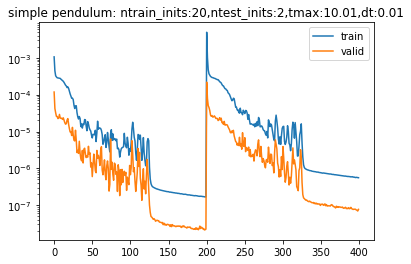

In [3]:
from model_type_I import HNN as HNN2
model_ft = HNN2(3, 200, 2, srate)
params = list(model_ft.parameters())
optimizer_ft = torch.optim.Adam(params, 1e-2)
lr_sched = torch.optim.lr_scheduler.StepLR(optimizer_ft,250,gamma=0.1)
trained_model2 = train_model(model_ft, optimizer_ft,lr_sched, num_epochs=200, energy_term=False,integrator_embedded=True, reg_grad=False)


epoch:0


/Users/shaan/anaconda3/envs/main/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train state loss 1.0140663385391235
train state loss 18.050827026367188
train state loss 1.9161652326583862
train state loss 2.285327911376953
train state loss 2.1485702991485596
train state loss 1.1940292119979858
train state loss 0.9972726106643677
train state loss 1.4278538227081299
train state loss 1.764528751373291
train state loss 1.6584643125534058
train state loss 1.3711471557617188
train state loss 1.0719174146652222
train state loss 0.9611576199531555
train state loss 0.9878270626068115
train Loss: 36.8491554260
valid state loss 1.1841669082641602
valid state loss 0.8693321347236633
valid Loss: 2.0534989834
epoch:1
train state loss 1.1133511066436768
train state loss 1.2005726099014282
train state loss 1.1326462030410767
train state loss 1.0816164016723633
train state loss 0.9913239479064941
train state loss 0.8620870113372803
train state loss 0.8371192216873169
train state loss 0.8536481261253357
train state loss 0.871084451675415
train state loss 0.8506550192832947
train st

valid state loss 0.13098329305648804
valid state loss 0.1483704000711441
valid Loss: 0.2793536782
epoch:13
train state loss 0.19330470263957977
train state loss 0.18899092078208923
train state loss 0.19615134596824646
train state loss 0.18630200624465942
train state loss 0.18635143339633942
train state loss 0.18626102805137634
train state loss 0.18918953835964203
train state loss 0.1915542185306549
train state loss 0.18025429546833038
train state loss 0.18388043344020844
train state loss 0.18709035217761993
train state loss 0.18354645371437073
train state loss 0.1935461014509201
train state loss 0.18440569937229156
train Loss: 2.6308286190
valid state loss 0.11433573067188263
valid state loss 0.14173167943954468
valid Loss: 0.2560673952
epoch:14
train state loss 0.1822582632303238
train state loss 0.18213632702827454
train state loss 0.18782570958137512
train state loss 0.1826903223991394
train state loss 0.17397525906562805
train state loss 0.18326038122177124
train state loss 0.18021

train state loss 0.12776564061641693
train state loss 0.11604063957929611
train state loss 0.1260024756193161
train state loss 0.12226185947656631
train Loss: 1.7403939962
valid state loss 0.08815780282020569
valid state loss 0.1178215742111206
valid Loss: 0.2059793770
epoch:26
train state loss 0.129208043217659
train state loss 0.11934257298707962
train state loss 0.12239138036966324
train state loss 0.12431991845369339
train state loss 0.12548072636127472
train state loss 0.12117447704076767
train state loss 0.12139439582824707
train state loss 0.11990942060947418
train state loss 0.12081478536128998
train state loss 0.12562377750873566
train state loss 0.12083356827497482
train state loss 0.11425458639860153
train state loss 0.1210455521941185
train state loss 0.12111183255910873
train Loss: 1.7069050074
valid state loss 0.07067636400461197
valid state loss 0.1023394837975502
valid Loss: 0.1730158478
epoch:27
train state loss 0.11573860794305801
train state loss 0.12366585433483124


train state loss 0.0443539172410965
train state loss 0.041949670761823654
train state loss 0.03924495726823807
train state loss 0.044233404099941254
train state loss 0.044523321092128754
train state loss 0.038689952343702316
train state loss 0.03933388367295265
train state loss 0.03768909350037575
train Loss: 0.6128708124
valid state loss 0.02663181722164154
valid state loss 0.03978405147790909
valid Loss: 0.0664158687
epoch:39
train state loss 0.040422260761260986
train state loss 0.03912133350968361
train state loss 0.03792480751872063
train state loss 0.036005549132823944
train state loss 0.03716890886425972
train state loss 0.03749274089932442
train state loss 0.037679992616176605
train state loss 0.033841848373413086
train state loss 0.03625938296318054
train state loss 0.031609442085027695
train state loss 0.03296855837106705
train state loss 0.03435492888092995
train state loss 0.03272562101483345
train state loss 0.02879461832344532
train Loss: 0.4963699877
valid state loss 0.0

train Loss: 0.0664207637
valid state loss 0.005705137271434069
valid state loss 0.0007264291634783149
valid Loss: 0.0064315666
epoch:51
train state loss 0.00461614178493619
train state loss 0.004452428314834833
train state loss 0.004191627725958824
train state loss 0.004217438865453005
train state loss 0.004786538891494274
train state loss 0.004587833769619465
train state loss 0.004875043872743845
train state loss 0.005005367565900087
train state loss 0.004655824042856693
train state loss 0.004403412342071533
train state loss 0.004561556037515402
train state loss 0.00413420470431447
train state loss 0.004334750585258007
train state loss 0.004589902237057686
train Loss: 0.0634120703
valid state loss 0.005560601595789194
valid state loss 0.0008323041256517172
valid Loss: 0.0063929055
epoch:52
train state loss 0.004651172552257776
train state loss 0.004167503211647272
train state loss 0.004422377794981003
train state loss 0.003967158496379852
train state loss 0.0040987092070281506
train s

train state loss 0.003210333874449134
train state loss 0.0035304666962474585
train state loss 0.0035386946983635426
train state loss 0.0038798735477030277
train state loss 0.0028766917530447245
train state loss 0.003188252681866288
train state loss 0.00376865710131824
train state loss 0.003816407872363925
train state loss 0.0035313863772898912
train state loss 0.0034196304623037577
train state loss 0.0036760142538696527
train state loss 0.0033134762197732925
train state loss 0.003489304333925247
train Loss: 0.0484534688
valid state loss 0.004242926370352507
valid state loss 0.0003843541198875755
valid Loss: 0.0046272804
epoch:64
train state loss 0.0034865313209593296
train state loss 0.0038219585549086332
train state loss 0.003112618112936616
train state loss 0.0034273299388587475
train state loss 0.0031911972910165787
train state loss 0.004021449945867062
train state loss 0.004523401148617268
train state loss 0.005179241299629211
train state loss 0.004098264500498772
train state loss 

train state loss 0.0024619486648589373
train state loss 0.003686714917421341
train state loss 0.002260058419778943
train state loss 0.0020659908186644316
train state loss 0.002126889070495963
train state loss 0.002267467323690653
train state loss 0.0030632473062723875
train state loss 0.002574583515524864
train Loss: 0.0359703228
valid state loss 0.0034407239872962236
valid state loss 0.0018390041077509522
valid Loss: 0.0052797282
epoch:76
train state loss 0.0033947632182389498
train state loss 0.002060933271422982
train state loss 0.0017424877732992172
train state loss 0.002874854952096939
train state loss 0.004166745115071535
train state loss 0.003968960139900446
train state loss 0.0025961012579500675
train state loss 0.0025677417870610952
train state loss 0.0035439361818134785
train state loss 0.004576298873871565
train state loss 0.0036796925123780966
train state loss 0.002572230063378811
train state loss 0.00222880020737648
train state loss 0.002386067993938923
train Loss: 0.04235

train state loss 0.0007341231685131788
train state loss 0.0007025392260402441
train state loss 0.0006791641935706139
train state loss 0.0008139058481901884
train state loss 0.0007455472950823605
train state loss 0.0008671323885209858
train Loss: 0.0110197691
valid state loss 0.0009406824829056859
valid state loss 0.0003164866066072136
valid Loss: 0.0012571691
epoch:88
train state loss 0.0008474336354993284
train state loss 0.0009369039325974882
train state loss 0.0007847140659578145
train state loss 0.0007725993636995554
train state loss 0.0008515850640833378
train state loss 0.0008124878513626754
train state loss 0.0006829349440522492
train state loss 0.0007066293037496507
train state loss 0.0008653776603750885
train state loss 0.0007971501909196377
train state loss 0.0007552691386081278
train state loss 0.0008239619783125818
train state loss 0.0007067241822369397
train state loss 0.0007979052024893463
train Loss: 0.0111416755
valid state loss 0.0010621488327160478
valid state loss 0.

train state loss 0.00038129035965539515
train state loss 0.0005236789584159851
train state loss 0.0007620758842676878
train state loss 0.001226526335813105
train state loss 0.0018798757810145617
train Loss: 0.0113355694
valid state loss 0.0027520074509084225
valid state loss 0.003599895630031824
valid Loss: 0.0063519031
epoch:100
train state loss 0.0027609532698988914
train state loss 0.002802841830998659
train state loss 0.002654219279065728
train state loss 0.002846712479367852
train state loss 0.002670546295121312
train state loss 0.001643296447582543
train state loss 0.000773200998082757
train state loss 0.0005400883383117616
train state loss 0.0008328151889145374
train state loss 0.0016647648299112916
train state loss 0.002593634882941842
train state loss 0.0037875401321798563
train state loss 0.005202785134315491
train state loss 0.007071204483509064
train Loss: 0.0378446057
valid state loss 0.0072669838555157185
valid state loss 0.009147773496806622
valid Loss: 0.0164147578
epoc

valid state loss 0.00026043239631690085
valid Loss: 0.0012752549
epoch:112
train state loss 0.000796587613876909
train state loss 0.0008233619737438858
train state loss 0.0007952865562401712
train state loss 0.0007470911368727684
train state loss 0.0006891312659718096
train state loss 0.0007995883352123201
train state loss 0.0008409575093537569
train state loss 0.0006285942508839071
train state loss 0.0007067679543979466
train state loss 0.0008535996894352138
train state loss 0.0006321700639091432
train state loss 0.0006494150729849935
train state loss 0.0007296615513041615
train state loss 0.0006288461736403406
train Loss: 0.0103210583
valid state loss 0.0006339516839943826
valid state loss 0.0002053161442745477
valid Loss: 0.0008392679
epoch:113
train state loss 0.0006120376056060195
train state loss 0.0008133381488732994
train state loss 0.0008309179684147239
train state loss 0.0005702461930923164
train state loss 0.0005759040359407663
train state loss 0.0007289017667062581
train st

valid state loss 0.0003807762113865465
valid state loss 0.0004054629825986922
valid Loss: 0.0007862392
epoch:124
train state loss 0.00047440241905860603
train state loss 0.000531655503436923
train state loss 0.00032109516905620694
train state loss 0.00036417916999198496
train state loss 0.0004179679963272065
train state loss 0.00034532888093963265
train state loss 0.00037578566116280854
train state loss 0.00035216272226534784
train state loss 0.00028106762329116464
train state loss 0.0003511561662890017
train state loss 0.0003884087491314858
train state loss 0.000329747301293537
train state loss 0.00028688294696621597
train state loss 0.0002924737345892936
train Loss: 0.0051123137
valid state loss 0.00032252640812657773
valid state loss 0.00019616670033428818
valid Loss: 0.0005186931
epoch:125
train state loss 0.00030082694138400257
train state loss 0.00030151157989166677
train state loss 0.0002551759534981102
train state loss 0.00023315026191994548
train state loss 0.00024473117082379

train state loss 0.00020102363487239927
train Loss: 0.0027592371
valid state loss 0.0002514845400582999
valid state loss 8.151848305715248e-05
valid Loss: 0.0003330030
epoch:136
train state loss 0.00019977589545305818
train state loss 0.00019932624127250165
train state loss 0.0001936467451741919
train state loss 0.00019701922428794205
train state loss 0.0001926176919369027
train state loss 0.00019709179468918592
train state loss 0.00019625444838311523
train state loss 0.0002078431425616145
train state loss 0.00020123364811297506
train state loss 0.00018636301683727652
train state loss 0.00018777252989821136
train state loss 0.00019528587290551513
train state loss 0.0001834840513765812
train state loss 0.0001775657437974587
train Loss: 0.0027152800
valid state loss 0.00024692839360795915
valid state loss 8.158198761520907e-05
valid Loss: 0.0003285104
epoch:137
train state loss 0.0001942198141478002
train state loss 0.0001957728818524629
train state loss 0.0001854910224210471
train state

train state loss 0.0001714555692160502
train state loss 0.0001815794239519164
train state loss 0.00017693196423351765
train state loss 0.00018499289581086487
train Loss: 0.0025233824
valid state loss 0.00022074425942264497
valid state loss 8.099964907160029e-05
valid Loss: 0.0003017439
epoch:148
train state loss 0.0001800749741960317
train state loss 0.00018802749400492758
train state loss 0.00018152255506720394
train state loss 0.00019352982053533196
train state loss 0.0001702798472251743
train state loss 0.00017149030463770032
train state loss 0.0001800793397706002
train state loss 0.00017444213153794408
train state loss 0.00017685392231214792
train state loss 0.00018089072545990348
train state loss 0.00018108430958818644
train state loss 0.00018047727644443512
train state loss 0.00017165490135084838
train state loss 0.00015442028234247118
train Loss: 0.0024848278
valid state loss 0.00022350039216689765
valid state loss 8.208167855627835e-05
valid Loss: 0.0003055821
epoch:149
train s

train state loss 0.00017016516358125955
train state loss 0.00016815567505545914
train state loss 0.0001684896124061197
train state loss 0.000161981864948757
train state loss 0.00016698145191185176
train state loss 0.0001586565194884315
train Loss: 0.0023293586
valid state loss 0.0002208637451985851
valid state loss 7.19686722732149e-05
valid Loss: 0.0002928324
epoch:160
train state loss 0.00017562102584633976
train state loss 0.0001594212808413431
train state loss 0.00016537193732801825
train state loss 0.00015776576765347272
train state loss 0.00017836992628872395
train state loss 0.0001771250827005133
train state loss 0.00015557880396954715
train state loss 0.00017511109763290733
train state loss 0.00016160648374352604
train state loss 0.00016962600057013333
train state loss 0.00016281915304716676
train state loss 0.00015911002992652357
train state loss 0.00015403555880766362
train state loss 0.00015210128913167864
train Loss: 0.0023036634
valid state loss 0.00022196189092937857
vali

train state loss 0.00015491236990783364
train state loss 0.00014813151210546494
train state loss 0.00014773083967156708
train state loss 0.00015857635298743844
train state loss 0.00014530780026689172
train state loss 0.00015386597078759223
train state loss 0.00016258306277450174
train state loss 0.00016728328773751855
train Loss: 0.0021581126
valid state loss 0.0002031980111496523
valid state loss 7.353416731348261e-05
valid Loss: 0.0002767322
epoch:172
train state loss 0.00014686236681882292
train state loss 0.00015804053691681474
train state loss 0.00015798122331034392
train state loss 0.00015148476813919842
train state loss 0.0001543160469736904
train state loss 0.00014361797366291285
train state loss 0.00015183376672212034
train state loss 0.00014874212502036244
train state loss 0.0001575495844008401
train state loss 0.00015938063734211028
train state loss 0.00015461730072274804
train state loss 0.00015585031360387802
train state loss 0.00015102175530046225
train state loss 0.00015

train state loss 0.00014513263886328787
train state loss 0.0001390528050251305
train state loss 0.000141586919198744
train state loss 0.0001431761629646644
train state loss 0.00014338188339024782
train state loss 0.00015050626825541258
train state loss 0.00014085978909861296
train state loss 0.00015640789933968335
train Loss: 0.0020135483
valid state loss 0.00017891883908305317
valid state loss 5.8699180954135954e-05
valid Loss: 0.0002376180
epoch:184
train state loss 0.00014050847676116973
train state loss 0.0001403039350407198
train state loss 0.00015021157742012292
train state loss 0.00013618532102555037
train state loss 0.00014159688726067543
train state loss 0.00014408346032723784
train state loss 0.00014514238864649087
train state loss 0.00014260203170124441
train state loss 0.0001492237497586757
train state loss 0.00014268627273850143
train state loss 0.00013816980936098844
train state loss 0.0001437252212781459
train state loss 0.0001361597969662398
train state loss 0.000139680

train state loss 0.0001359013986075297
train state loss 0.0001407450472470373
train state loss 0.00013258331455290318
train state loss 0.00013148323341738433
train state loss 0.0001345840428257361
train state loss 0.0001270440116059035
train state loss 0.00012544705532491207
train state loss 0.0001115496052079834
train Loss: 0.0018452785
valid state loss 0.00016245472943410277
valid state loss 5.667854202329181e-05
valid Loss: 0.0002191333
epoch:196
train state loss 0.00012382827117107809
train state loss 0.00013024872168898582
train state loss 0.0001296544069191441
train state loss 0.00012035475083393976
train state loss 0.0001273687812499702
train state loss 0.00012116931611672044
train state loss 0.00014139607083052397
train state loss 0.0001299798459513113
train state loss 0.00013819309242535383
train state loss 0.00014143345470074564
train state loss 0.00013889593537896872
train state loss 0.00014034798368811607
train state loss 0.0001351074897684157
train state loss 0.00013052574

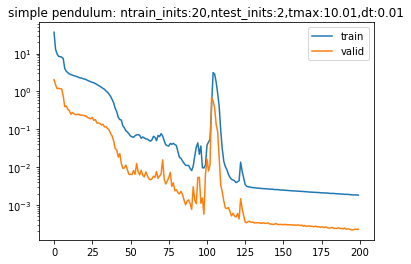

In [2]:
from model_type_II import HNN as HNN3
model_ft = HNN3(2, 200, 1, srate)
params = list(model_ft.parameters())
optimizer_ft = torch.optim.Adam(params, 1e-2)
lr_sched = torch.optim.lr_scheduler.StepLR(optimizer_ft,250,gamma=0.1)
trained_model3 = train_model(model_ft, optimizer_ft,lr_sched, num_epochs=200, energy_term=False,integrator_embedded=False, reg_grad=False)

# torch.save(trained_model,'HNN_painleve')

#### MAKE SURE TO SPECIFY THE MODEL TYPE UNDER INFERENCE MODEL

In [4]:
"""
Author: ***
Code to produce the results obtained in VIGN: Variational Integrator Graph Networks

"""

# %%


inference_model = trained_model3

n_test_traj = 1
num_nodes = 2
T_max_t = 10.01
dt = 0.01
srate = 0.01

bs = int(T_max_t//dt)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

# train_data = pend_chaos(num_trajectories, T_max, dt, srate, 0)#pendulum(num_trajectories, T_max, dt, srate, noise_std=0, seed=3)
valid_data = pend_chaos(n_test_traj, T_max_t, dt, srate, 1)#pendulum(n_test_traj, T_max_t, dt, srate, noise_std=0, seed=5)

# tnow, tnext, tenergy, tdx,tevals = nownext(train_data, num_trajectories, T_max, dt, srate)
vnow, vnext, venergy, vdx,vevals = nownext(valid_data, n_test_traj, T_max_t, dt, srate)


# traindat = pendpixdata(tnow, tnext, tenergy, tdx,tevals)
# train_dataloader = DataLoader(traindat, batch_size=200, num_workers=2, shuffle=True)
valdat = pendpixdata(vnow, vnext, venergy, vdx,vevals)
val_dataloader = DataLoader(valdat, batch_size=bs, num_workers=2, shuffle=False)

data_dict = { 'valid': val_dataloader}
running_losses = 0.
loss_collater = {'train': [], 'valid': []}


phase = 'valid'

main_pred =[]
for batch_i, (q, q_next, energy_, qdx,tevals) in enumerate(data_dict['valid']):
    if phase == 'train':
        optimizer.zero_grad()
    q, q_next, qdx = q.float(), q_next.float(), qdx.float()
    q.to(device)
    q_next.to(device)
    energy_.to(device)
    qdx.to(device)
    tevals = tevals.float()
    tevals.to(device)
    loss = 0
    q.requires_grad = True
    tevals.requires_grad = True

    qinit = q[0].reshape(1, -1)

    preds = []
    for i in range(len(q_next)):
        next_step_pred = inference_model.next_step(qinit,tevals[i])
        preds.append(next_step_pred)
        qinit = next_step_pred

    preds = torch.cat(preds).detach().numpy()
    q_next = q_next.detach().numpy()

    main_pred.append((preds,q_next))
    

cpu


KeyboardInterrupt: 

In [5]:
preds = torch.cat(preds).detach().numpy()
q_next = q_next.detach().numpy()

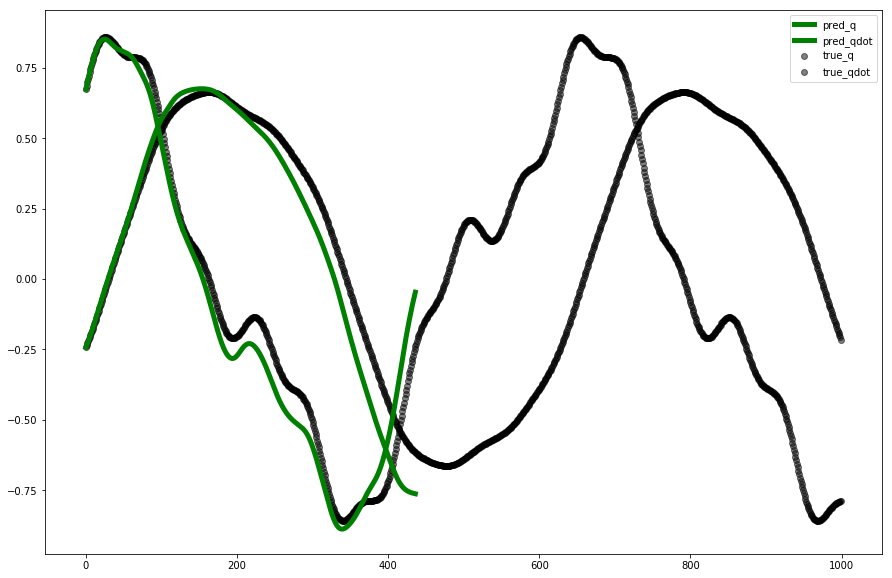

In [14]:
for j in range(n_test_traj):
#     preds,q_next = main_pred[j]
    plt.figure(figsize=(15,10))
    plt.scatter(range(len(q_next)),q_next[:,0],c='black',label='true_q',alpha=.5)
    plt.scatter(range(len(q_next)),q_next[:,1],c='black',label='true_qdot',alpha=.5)
    plt.plot(preds[:,0],c='green',label='pred_q',linewidth=5.0)
    plt.plot(preds[:,1],c='green',label='pred_qdot',linewidth=5.0)
    plt.legend(loc='best')

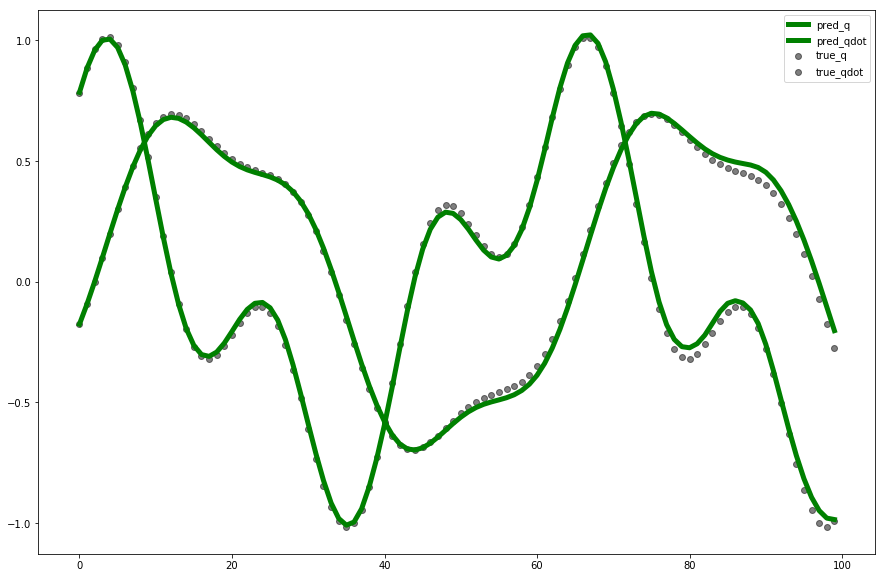

In [8]:
for j in range(n_test_traj):
    preds,q_next = main_pred[j]
    plt.figure(figsize=(15,10))
    plt.scatter(range(len(q_next)),q_next[:,0],c='black',label='true_q',alpha=.5)
    plt.scatter(range(len(q_next)),q_next[:,1],c='black',label='true_qdot',alpha=.5)
    plt.plot(preds[:,0],c='green',label='pred_q',linewidth=5.0)
    plt.plot(preds[:,1],c='green',label='pred_qdot',linewidth=5.0)
    plt.legend(loc='best')

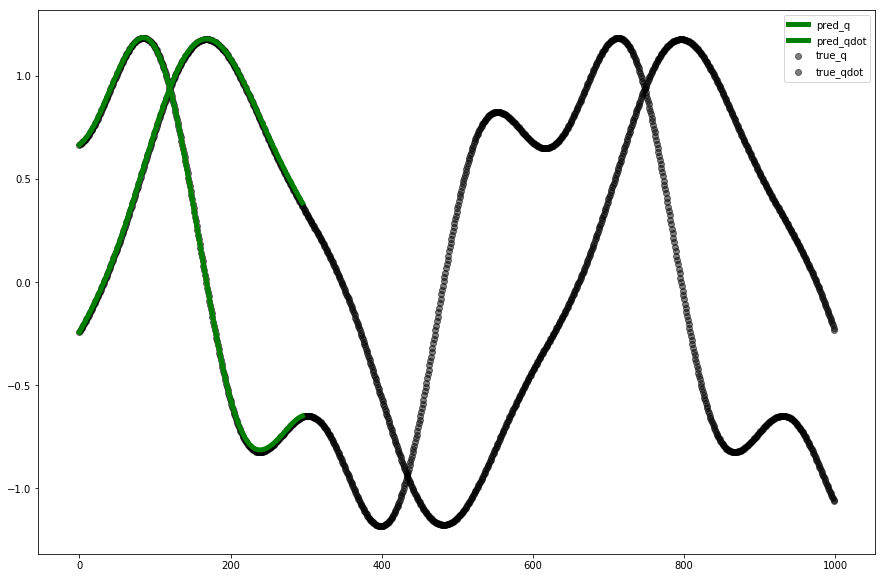

In [6]:
for j in range(n_test_traj):
#     preds,q_next = main_pred[j]
    plt.figure(figsize=(15,10))
    plt.scatter(range(len(q_next)),q_next[:,0],c='black',label='true_q',alpha=.5)
    plt.scatter(range(len(q_next)),q_next[:,1],c='black',label='true_qdot',alpha=.5)
    plt.plot(preds[:,0],c='green',label='pred_q',linewidth=5.0)
    plt.plot(preds[:,1],c='green',label='pred_qdot',linewidth=5.0)
    plt.legend(loc='best')

In [7]:
tevals.shape

torch.Size([1000])

In [7]:
tsteps =tevals.detach().numpy()

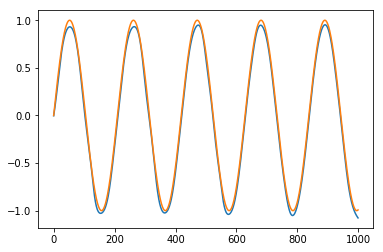

In [9]:
plt.plot(trained_model3.get_F(tevals.reshape(-1,1)).detach().numpy())
plt.plot(np.sin(3*tsteps))

## evidence suggests that learning the force separately leads to better inference despite comparable state loss.. basically the new regularization only helps a little

In [8]:
torch.tensor(tnow).split(1,1)

(tensor([[0.2323],
         [0.2426],
         [0.2529],
         ...,
         [0.6765],
         [0.6699],
         [0.6633]], dtype=torch.float64), tensor([[ 1.0241],
         [ 1.0317],
         [ 1.0392],
         ...,
         [-0.6529],
         [-0.6588],
         [-0.6644]], dtype=torch.float64))

In [9]:
tnow

array([[ 0.2323083 ,  1.02410753],
       [ 0.24258759,  1.0317316 ],
       [ 0.25294256,  1.03924355],
       ...,
       [ 0.6764828 , -0.65291534],
       [ 0.66992368, -0.6588496 ],
       [ 0.66330703, -0.66441935]])